## Imports

In [6]:
import re
import nltk
import string
import numpy as np
import pandas as pd
from collections import Counter

from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_samples, silhouette_score

nltk.download("stopwords")

[nltk_data] Downloading package stopwords to C:\Users\El
[nltk_data]     Professor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Read data

In [7]:
def read_input_file(input_file_name):
    return pd.read_csv(input_file_name,error_bad_lines=False, engine="python")


def get_test_df(df,null_column_name):
    return df[df[null_column_name].isnull()]


def split_df(df,percentage):

    train=df.sample(frac=percentage,random_state=200)
    test=df.drop(train.index)

    return train,test


def strip_html(df,column_name):

    stripped_column=[]

    for row in df.iterrows():
        soup = BeautifulSoup(row[1]['job_description'])
        stripped_column.append(soup.get_text())

    return stripped_column

In [8]:
input_file_name='C:/Users/El Professor/Desktop/input_seniority_new.csv'
null_column_name='seniority_name'

df=read_input_file(input_file_name)

C:\Users\El Professor\AppData\Local\Temp\ipykernel_34836\3502488400.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  return pd.read_csv(input_file_name,error_bad_lines=False, engine="python")
Skipping line 51: ',' expected after '"'
Skipping line 52: ',' expected after '"'
Skipping line 53: ',' expected after '"'
Skipping line 60: ',' expected after '"'
Skipping line 72: ',' expected after '"'
Skipping line 75: ',' expected after '"'
Skipping line 87: ',' expected after '"'
Skipping line 88: ',' expected after '"'
Skipping line 109: ',' expected after '"'
Skipping line 118: ',' expected after '"'
Skipping line 144: ',' expected after '"'
Skipping line 148: ',' expected after '"'
Skipping line 158: ',' expected after '"'
Skipping line 160: ',' expected after '"'
Skipping line 166: ',' expected after '"'
Skipping line 177: ',' expected after '"'
Skipping line 190: ',' expected after '"'
Skip

In [9]:
test_df=get_test_df(df,null_column_name)

df=df.dropna(subset=['seniority_name'])

df["stripped_job_description"]=strip_html(df,"job_description")
test_df["stripped_job_description"]=strip_html(test_df,"job_description")

train_split,test_split=split_df(df,0.7)

print(f"Length of Dataset with Null Seniority Values(Unseen Test Dataset):{len(test_df)}")
print(f"Length of Original Dataset without Null Values:{len(df)}")
print(f"Length of 70% Split(Train Dataset):{len(train_split)}")
print(f"Length of 30% Split(Test Dataset):{len(test_split)}")

C:\Python310\lib\site-packages\bs4\__init__.py:404: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Length of Dataset with Null Seniority Values(Unseen Test Dataset):5644
Length of Original Dataset without Null Values:7407
Length of 70% Split(Train Dataset):5185
Length of 30% Split(Test Dataset):2222


In [10]:
print("Sample of Dataset Original Dataset without Null Values.")
print("#######################################")
print(df.iloc[0])
print("Sample of Dataset with Null Seniority Values(Test Dataset).")
print("#######################################")
print(test_df.iloc[0])
print("Sample of 70% Split(Train Dataset).")
print("#######################################")
print(train_split.iloc[0])
print("Sample of 30% Split(Test Dataset).")
print("#######################################")
print(test_split.iloc[0])

Sample of Dataset Original Dataset without Null Values.
#######################################
title                           Business Operations and Marketing Coordinator
job_description             <p><strong>Job opportunity: </strong></p><p>Bu...
job_title_tag_name                                                        NaN
location                                    Abingdon, England, United Kingdom
salary                                                      £24,000 - £24,000
category_name                                                             NaN
seniority_name                                                         Junior
date_crawled                                                       2022-04-02
stripped_job_description    Job opportunity: Business Operations and Marke...
Name: 5, dtype: object
Sample of Dataset with Null Seniority Values(Test Dataset).
#######################################
title                       Presales Solution Architect Fulltime remote jo...
j

## Clean data

### Define function to clean and tokenize

In [11]:
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    
    return tokens

In [12]:
custom_stopwords = set(stopwords.words("english") + [""])
text_columns = ["stripped_job_description"]

def pre_process_dataset(dataframe):    

    df = dataframe.copy()
    df["stripped_job_description"] = df["stripped_job_description"].fillna("")

    for col in text_columns:
        df[col] = df[col].astype(str)

    # Create text column based on title, description, and content
    df["text"] = df[text_columns].apply(lambda x: " | ".join(x), axis=1)
    df["tokens"] = df["text"].map(lambda x: clean_text(x, word_tokenize, custom_stopwords))
    df["seniority_name"]=dataframe["seniority_name"]
    # Remove duplicated after preprocessing
    _, idx = np.unique(df["tokens"], return_index=True)
    df = df.iloc[idx, :]

    # Remove empty values
    df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["text", "tokens","seniority_name"]]

    print(f"Original dataframe: {dataframe.shape}")
    print(f"Pre-processed dataframe: {df.shape}")
    return df

In [13]:
df=pre_process_dataset(train_split)

Original dataframe: (5185, 9)
Pre-processed dataframe: (4788, 3)


In [14]:
df_test=pre_process_dataset(test_split)

Original dataframe: (2222, 9)
Pre-processed dataframe: (2112, 3)


### Apply function and remove duplicates

In [15]:
df.head()

,text,tokens,seniority_name
7982,100-120kWork 100% remotelyShare OptionsMeet Th...,"[120kwork, remotelyshare, optionsmeet, gurures...",Senior
4053,At 33n our mission is simple: to improve care ...,"[33n, mission, simple, improve, care, empoweri...",Intermediate
8896,37signals is hiring a Senior Product Designer ...,"[37signals, hiring, senior, product, designer,...",Senior
13011,NO 3RD PARTY VENDORS PLEASECLIENT UNABLE TO SP...,"[3rd, party, vendors, pleaseclient, unable, sp...",Intermediate
9408,We have 6GW solar cells and 2GW solar module c...,"[6gw, solar, cells, 2gw, solar, module, capaci...",Intermediate


In [16]:
df_test.head()

,text,tokens,seniority_name
9788,33Vincent/Base matches highly skilled & experi...,"[33vincentbase, matches, highly, skilled, expe...",Intermediate
6396,6ix Inc. is a financial technology company on ...,"[6ix, inc, financial, technology, company, mis...",Intermediate
6403,6ix Inc. is a financial technology company on ...,"[6ix, inc, financial, technology, company, mis...",Junior
2855,A1 SEO is a digital marketing agency that spec...,"[a1, seo, digital, marketing, agency, speciali...",Intermediate
5190,"AboutWe help early-stage companies design, bui...","[aboutwe, help, early, stage, companies, desig...",Expert


### Check vocabulary

In [17]:
def check_vocabulary(df):
    
    docs = df["text"].values
    tokenized_docs = df["tokens"].values
    vocab = Counter()
    
    for token in tokenized_docs:
        vocab.update(token)
        
    return docs,tokenized_docs,vocab

In [18]:
docs,tokenized_docs,vocab=check_vocabulary(df)

In [19]:
vocab.most_common(10)

[('experience', 14811),
 ('team', 11961),
 ('work', 11487),
 ('business', 10029),
 ('data', 9646),
 ('development', 7058),
 ('years', 6850),
 ('working', 6644),
 ('management', 6275),
 ('new', 5674)]

In [20]:
test_docs,test_tokenized_docs,test_vocab=check_vocabulary(df_test)

In [21]:
test_vocab.most_common(10)

[('experience', 6693),
 ('team', 5310),
 ('work', 5060),
 ('business', 4250),
 ('data', 4073),
 ('development', 2974),
 ('years', 2912),
 ('working', 2892),
 ('management', 2683),
 ('skills', 2378)]

## Generate vectors from document

### Define function for creating a single vectors from word embeddings

In [22]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

### Apply function to previously pre-processed text

In [23]:
def get_model(size):
    return Word2Vec(sentences=tokenized_docs, vector_size=size, workers=1, seed=42)

In [24]:
model=get_model(512)
model.wv.most_similar("expert")

[('matter', 0.8012547492980957),
 ('expertise', 0.7546048760414124),
 ('subject', 0.7514514923095703),
 ('domain', 0.6934988498687744),
 ('experts', 0.6684445142745972),
 ('deep', 0.6515989303588867),
 ('requirementsyou', 0.5830179452896118),
 ('depth', 0.5698365569114685),
 ('conduit', 0.5561776757240295),
 ('sme', 0.5521451234817505)]

In [25]:
vectorized_docs = vectorize(tokenized_docs, model=model)
len(vectorized_docs), len(vectorized_docs[0])

(4788, 512)

In [26]:
test_model=get_model(512)
test_model.wv.most_similar("expert")

[('matter', 0.8012547492980957),
 ('expertise', 0.7546048760414124),
 ('subject', 0.7514514923095703),
 ('domain', 0.6934988498687744),
 ('experts', 0.6684445142745972),
 ('deep', 0.6515989303588867),
 ('requirementsyou', 0.5830179452896118),
 ('depth', 0.5698365569114685),
 ('conduit', 0.5561776757240295),
 ('sme', 0.5521451234817505)]

In [27]:
test_vectorized_docs = vectorize(test_tokenized_docs, model=test_model)
len(test_vectorized_docs), len(test_vectorized_docs[0])

(2112, 512)

### Generate and analyze clusters

In [28]:
def mbkmeans_clusters(X, k, mb=500, print_silhouette_values=False):
    """Generate clusters.

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches. Defaults to 500.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [29]:
def get_updated_df(df,docs,tokenized_docs,cluster_labels):
    
    df_clusters = pd.DataFrame({
        "text": docs,
        "tokens": [" ".join(text) for text in tokenized_docs],
        "cluster": cluster_labels,
        "seniority_name":df['seniority_name']
    })
    
    return df_clusters

In [30]:
clustering, cluster_labels = mbkmeans_clusters(X=vectorized_docs, k=4, print_silhouette_values=True)
df_clusters=get_updated_df(df,docs,tokenized_docs,cluster_labels)

For n_clusters = 4
Silhouette coefficient: 0.13
Inertia:10687.223600861484
Silhouette values:
    Cluster 1: Size:1920 | Avg:0.16 | Min:0.02 | Max: 0.35
    Cluster 2: Size:1321 | Avg:0.11 | Min:-0.02 | Max: 0.28
    Cluster 3: Size:1067 | Avg:0.10 | Min:-0.04 | Max: 0.30
    Cluster 0: Size:480 | Avg:0.08 | Min:-0.07 | Max: 0.27


In [31]:
print("Top terms per cluster (based on centroids):")
for i in range(4):
    tokens_per_cluster = ""
    most_representative = model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Top terms per cluster (based on centroids):
Cluster 0: developmentunderstanding toolshave systemsstrong engineerexperience skills2 
Cluster 1: companyyou conceive blend doingworking instrumental 
Cluster 2: teams· solutions· team• projects· toolshave 
Cluster 3: formulates leadership• budgetary accountabilities activities• 


In [32]:
df_clusters.head()

,text,tokens,cluster,seniority_name
7982,100-120kWork 100% remotelyShare OptionsMeet Th...,120kwork remotelyshare optionsmeet gururesourc...,1,Senior
4053,At 33n our mission is simple: to improve care ...,33n mission simple improve care empowering fro...,2,Intermediate
8896,37signals is hiring a Senior Product Designer ...,37signals hiring senior product designer mobil...,1,Senior
13011,NO 3RD PARTY VENDORS PLEASECLIENT UNABLE TO SP...,3rd party vendors pleaseclient unable sponsor ...,0,Intermediate
9408,We have 6GW solar cells and 2GW solar module c...,6gw solar cells 2gw solar module capacity thai...,3,Intermediate


In [33]:
model_predictions=clustering.predict(test_vectorized_docs)
test_df_clusters = get_updated_df(df_test,test_docs,test_tokenized_docs,model_predictions)

In [34]:
test_df_clusters.head()

,text,tokens,cluster,seniority_name
9788,33Vincent/Base matches highly skilled & experi...,33vincentbase matches highly skilled experienc...,1,Intermediate
6396,6ix Inc. is a financial technology company on ...,6ix inc financial technology company mission u...,1,Intermediate
6403,6ix Inc. is a financial technology company on ...,6ix inc financial technology company mission u...,1,Junior
2855,A1 SEO is a digital marketing agency that spec...,a1 seo digital marketing agency specialises se...,1,Intermediate
5190,"AboutWe help early-stage companies design, bui...",aboutwe help early stage companies design buil...,1,Expert


In [71]:
for token in test_df_clusters.iterrows():
    print(token[1]['tokens'])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [35]:
label_list=["Senior","Junior","Intermediate","Expert"]

def convert_seniority(df1):
    
    actual_seniority=[]
    predicted_seniority=[]
    predicted_seniority_text=[] 
    actual_seniority_text=[]
    
    for row in df1.iterrows():
        
        predicted_seniority.append(row[1]['cluster'])
        actual_seniority_text.append(row[1]['seniority_name'])
    
        if row[1]['seniority_name']==label_list[0]:
            actual_seniority.append(0)

        if row[1]['seniority_name']==label_list[1]:
            actual_seniority.append(1)

        if row[1]['seniority_name']==label_list[2]:
            actual_seniority.append(2)

        if row[1]['seniority_name']==label_list[3]:
            actual_seniority.append(3)
            
        if row[1]['cluster']==0:
            predicted_seniority_text.append(label_list[0])
        if row[1]['cluster']==1:
            predicted_seniority_text.append(label_list[1])
        if row[1]['cluster']==2:
            predicted_seniority_text.append(label_list[2])
        if row[1]['cluster']==3:
            predicted_seniority_text.append(label_list[3])
    
    return actual_seniority,predicted_seniority,actual_seniority_text,predicted_seniority_text

In [36]:
from operator import countOf
def get_counter(array,number):
    return countOf(array, number)

In [37]:
def get_accuracy(original_value,predicted_value,actual_seniority_text,predicted_seniority_text):
    #["Senior","Junior","Intermediate","Expert"]
    senior_count=get_counter(original_value,0)
    junior_count=get_counter(original_value,1)
    intermediate_count=get_counter(original_value,2)
    expert_count=get_counter(original_value,3)
    originals={}

    pred_senior_count=get_counter(predicted_value,0)
    pred_junior_count=get_counter(predicted_value,1)
    pred_intermediate_count=get_counter(predicted_value,2)
    pred_expert_count=get_counter(predicted_value,3)
    predictions={}

    accur_senior_count=0
    accur_junior_count=0
    accur_intermediate_count=0
    accur_expert_count=0
    accurate_predictions={}
    
    #original_value=actual_seniority_text
    #predicted_value=predicted_seniority_text
    
    for i in range(len(original_value)):
        
        if original_value[i]==0:
            if predicted_value[i]==0:
                accur_senior_count+=1
                
        if original_value[i]==1:
            if predicted_value[i]==1:
                accur_junior_count+=1
          
        if original_value[i]==2:
            if predicted_value[i]==2:
                accur_intermediate_count+=1
           
        if original_value[i]==3:
            if predicted_value[i]==3:
                accur_expert_count+=1
           
    
    originals['junior_count']=junior_count
    originals['intermediate_count']=intermediate_count
    originals['senior_count']=senior_count
    originals['expert_count']=expert_count
    
    predictions['junior_count']=pred_junior_count
    predictions['intermediate_count']=pred_intermediate_count
    predictions['senior_count']=pred_senior_count
    predictions['expert_count']=pred_expert_count
    
    accurate_predictions['junior_count']=accur_junior_count
    accurate_predictions['intermediate_count']=accur_intermediate_count
    accurate_predictions['senior_count']=accur_senior_count
    accurate_predictions['expert_count']=accur_expert_count
    
    return originals,predictions,accurate_predictions

In [41]:
def get_final_accuracy(actual_seniority,predicted_seniority,actual_seniority_text,predicted_seniority_text,name):
    
    originals,predictions,accurate_predictions=get_accuracy(actual_seniority,predicted_seniority,actual_seniority_text,predicted_seniority_text)

    accuracy=accurate_predictions['junior_count']+accurate_predictions['intermediate_count']+accurate_predictions['senior_count']+accurate_predictions['expert_count']

    print(f"Accuracy:{name}")
    print(f"Cluster[0,1,2,3]={label_list}")
    print(f"{accuracy}/{len(actual_seniority)}\n\n")

    print("#########")  
    print(f"Senior Count {name}:{originals['senior_count']}")
    print(f"Junior Count in {name}:{originals['junior_count']}")
    print(f"Intermediate Count {name}:{originals['intermediate_count']}")
    print(f"Expert Count {name}:{originals['expert_count']}")
    print("#########")
    print(f"Predicted Senior Count:{predictions['senior_count']}")
    print(f"Predicted Junior Count:{predictions['junior_count']}")
    print(f"Predicted Intermediate Count:{predictions['intermediate_count']}")
    print(f"Predicted Expert Count:{predictions['expert_count']}")
    print("#########")
    print(f"Accurate Senior Count:{accurate_predictions['senior_count']}")
    print(f"Accurate Junior Count:{accurate_predictions['junior_count']}")
    print(f"Accurate Intermediate Count:{accurate_predictions['intermediate_count']}")
    print(f"Accurate Expert Count:{accurate_predictions['expert_count']}")
    

In [59]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
def get_confusion_matrix(actual_seniority, predicted_seniority):
    return confusion_matrix(actual_seniority, predicted_seniority)



In [61]:
import matplotlib.pyplot as plt 
import seaborn as sns

def display_cmatrix_prec(cf_matrix):
    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
                fmt='.2%', cmap='Blues')

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Senior', 'Junior', 'Expert', 'Intermediate'])
    ax.yaxis.set_ticklabels(['Senior', 'Junior', 'Expert', 'Intermediate'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [62]:
actual_seniority,predicted_seniority,actual_seniority_text,predicted_seniority_text=convert_seniority(df_clusters)

get_final_accuracy(actual_seniority,predicted_seniority,actual_seniority_text,predicted_seniority_text,"Train_Split")

Accuracy:Train_Split
Cluster[0,1,2,3]=['Senior', 'Junior', 'Intermediate', 'Expert']
1310/4788


#########
Senior Count Train_Split:1013
Junior Count in Train_Split:727
Intermediate Count Train_Split:2328
Expert Count Train_Split:720
#########
Predicted Senior Count:480
Predicted Junior Count:1920
Predicted Intermediate Count:1321
Predicted Expert Count:1067
#########
Accurate Senior Count:136
Accurate Junior Count:358
Accurate Intermediate Count:650
Accurate Expert Count:166


In [63]:
senior = pd.Series(actual_seniority, name='Actual')
pred_senior = pd.Series(predicted_seniority, name='Predicted')
pad=pd.crosstab(senior, pred_senior)
print(pad)

Predicted    0    1    2    3
Actual                       
0          136  334  328  215
1           50  358  154  165
2          231  926  650  521
3           63  302  189  166


<AxesSubplot:>

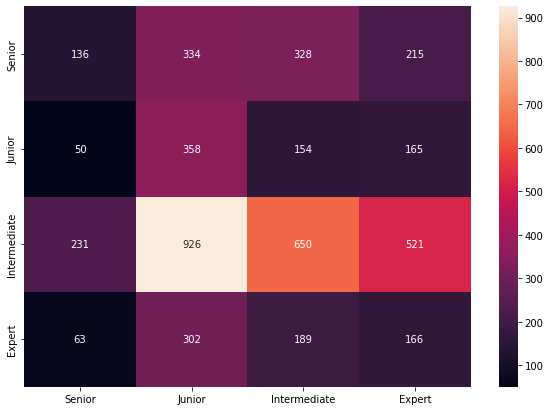

In [64]:
import matplotlib.pyplot as plt 
import seaborn as sn

array = [[pad[0][0],pad[1][0],pad[2][0],pad[3][0]], 
        [pad[0][1],pad[1][1],pad[2][1],pad[3][1]], 
        [pad[0][2],pad[1][2],pad[2][2],pad[3][2]], 
        [pad[0][3],pad[1][3],pad[2][3],pad[3][3]]]

names=['Senior', 'Junior', 'Intermediate', 'Expert']

df_cm = pd.DataFrame(array, index = [name for name in names],
                  columns = [name for name in names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g')

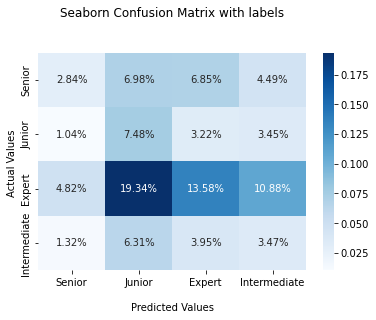

In [65]:
cf_matrix=get_confusion_matrix(actual_seniority, predicted_seniority)
display_cmatrix_prec(cf_matrix)

In [66]:
actual_seniority,predicted_seniority,actual_seniority_text,predicted_seniority_text=convert_seniority(test_df_clusters)
    
get_final_accuracy(actual_seniority,predicted_seniority,actual_seniority_text,predicted_seniority_text,"Test_Split")

Accuracy:Test_Split
Cluster[0,1,2,3]=['Senior', 'Junior', 'Intermediate', 'Expert']
575/2112


#########
Senior Count Test_Split:496
Junior Count in Test_Split:301
Intermediate Count Test_Split:1030
Expert Count Test_Split:285
#########
Predicted Senior Count:229
Predicted Junior Count:805
Predicted Intermediate Count:602
Predicted Expert Count:476
#########
Accurate Senior Count:69
Accurate Junior Count:139
Accurate Intermediate Count:300
Accurate Expert Count:67


In [67]:
senior = pd.Series(actual_seniority, name='Actual')
pred_senior = pd.Series(predicted_seniority, name='Predicted')
pad2=pd.crosstab(senior, pred_senior)
print(pad2)

Predicted    0    1    2    3
Actual                       
0           69  157  165  105
1           21  139   65   76
2          113  389  300  228
3           26  120   72   67


<AxesSubplot:>

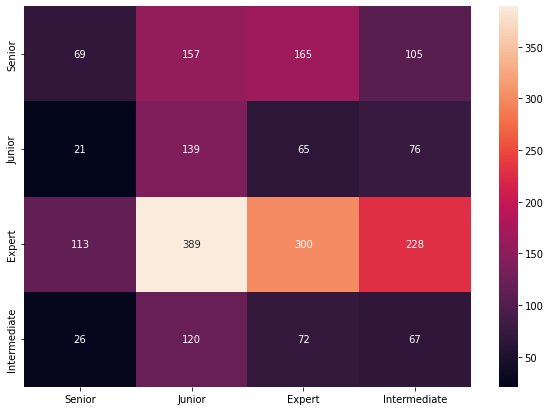

In [68]:
import matplotlib.pyplot as plt 
import seaborn as sn

array = [[pad2[0][0],pad2[1][0],pad2[2][0],pad2[3][0]], 
        [pad2[0][1],pad2[1][1],pad2[2][1],pad2[3][1]], 
        [pad2[0][2],pad2[1][2],pad2[2][2],pad2[3][2]], 
        [pad2[0][3],pad2[1][3],pad2[2][3],pad2[3][3]]]

names=['Senior', 'Junior', 'Expert', 'Intermediate']

df_cm = pd.DataFrame(array, index = [name for name in names],
                  columns = [name for name in names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g')

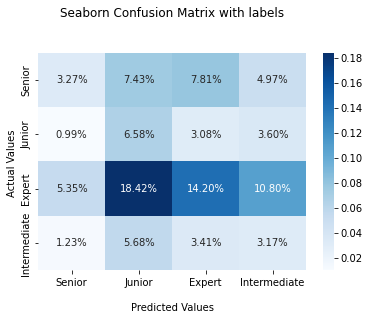

In [69]:
cf_matrix=get_confusion_matrix(actual_seniority, predicted_seniority)
display_cmatrix_prec(cf_matrix)